In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#load data
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
item_catigories = pd.read_csv('items.csv')
catigories = pd.read_csv('item_categories.csv')


In [3]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [5]:
test.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [6]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


In [7]:
item_catigories.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [8]:
item_catigories.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


In [9]:
catigories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [10]:
catigories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


(array([2.935834e+06, 1.300000e+01, 1.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([ -22. ,  416.2,  854.4, 1292.6, 1730.8, 2169. ]),
 <a list of 5 Patch objects>)

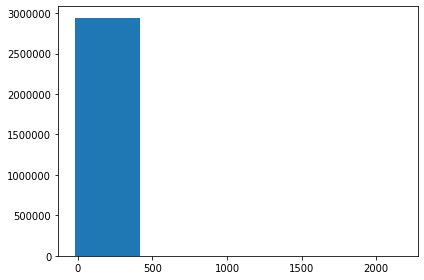

In [11]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

axs.hist(train['item_cnt_day'], bins=5)


In [12]:
train = train.loc[(train.item_cnt_day < 669)]

# train.date = train.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
# train.date = train.date.apply(lambda x:dt.datetime.strftime(x,'%Y-%m'))

In [13]:
data = train.groupby(['date_block_num','item_id','shop_id']).sum().reset_index()
# print(data)
data = data[['date_block_num','item_id','shop_id','item_cnt_day','item_price']]

# table = pd.pivot_table(data, values='item_cnt_day', index=['item_id', 'shop_id'],
#                         columns=['date_block_num'], aggfunc=np.sum).reset_index()
table = pd.pivot_table(data, values=['item_cnt_day', 'item_price'], index=['item_id', 'shop_id'], columns=['date_block_num'],
                       aggfunc={'item_cnt_day': np.sum,'item_price': max}).reset_index()
table = table.fillna(0)

item_catigories = item_catigories[['item_id','item_category_id']]
#get rid of those not in test data
data_form = test.merge(table, on = ['item_id', 'shop_id'], how = 'left')
data_form = item_catigories.merge(table, on = 'item_id', how = 'right')

data_form = data_form.fillna(0)



/Users/brandonpurcell@ibm.com/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/Users/brandonpurcell@ibm.com/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [14]:
data_form.columns

Index([           'item_id',   'item_category_id',      ('shop_id', ''),
        ('item_cnt_day', 0),  ('item_cnt_day', 1),  ('item_cnt_day', 2),
        ('item_cnt_day', 3),  ('item_cnt_day', 4),  ('item_cnt_day', 5),
        ('item_cnt_day', 6),  ('item_cnt_day', 7),  ('item_cnt_day', 8),
        ('item_cnt_day', 9), ('item_cnt_day', 10), ('item_cnt_day', 11),
       ('item_cnt_day', 12), ('item_cnt_day', 13), ('item_cnt_day', 14),
       ('item_cnt_day', 15), ('item_cnt_day', 16), ('item_cnt_day', 17),
       ('item_cnt_day', 18), ('item_cnt_day', 19), ('item_cnt_day', 20),
       ('item_cnt_day', 21), ('item_cnt_day', 22), ('item_cnt_day', 23),
       ('item_cnt_day', 24), ('item_cnt_day', 25), ('item_cnt_day', 26),
       ('item_cnt_day', 27), ('item_cnt_day', 28), ('item_cnt_day', 29),
       ('item_cnt_day', 30), ('item_cnt_day', 31), ('item_cnt_day', 32),
       ('item_cnt_day', 33),    ('item_price', 0),    ('item_price', 1),
          ('item_price', 2),    ('item_price', 3), 

In [15]:
data_form.head()

,item_id,item_category_id,"(shop_id, )","(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_price, 24)","(item_price, 25)","(item_price, 26)","(item_price, 27)","(item_price, 28)","(item_price, 29)","(item_price, 30)","(item_price, 31)","(item_price, 32)","(item_price, 33)"
0,0,40,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,76,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,40,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,40,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,40,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
data_form = data_form.iloc[:,3:]


In [17]:
data_form.columns

Index([ ('item_cnt_day', 0),  ('item_cnt_day', 1),  ('item_cnt_day', 2),
        ('item_cnt_day', 3),  ('item_cnt_day', 4),  ('item_cnt_day', 5),
        ('item_cnt_day', 6),  ('item_cnt_day', 7),  ('item_cnt_day', 8),
        ('item_cnt_day', 9), ('item_cnt_day', 10), ('item_cnt_day', 11),
       ('item_cnt_day', 12), ('item_cnt_day', 13), ('item_cnt_day', 14),
       ('item_cnt_day', 15), ('item_cnt_day', 16), ('item_cnt_day', 17),
       ('item_cnt_day', 18), ('item_cnt_day', 19), ('item_cnt_day', 20),
       ('item_cnt_day', 21), ('item_cnt_day', 22), ('item_cnt_day', 23),
       ('item_cnt_day', 24), ('item_cnt_day', 25), ('item_cnt_day', 26),
       ('item_cnt_day', 27), ('item_cnt_day', 28), ('item_cnt_day', 29),
       ('item_cnt_day', 30), ('item_cnt_day', 31), ('item_cnt_day', 32),
       ('item_cnt_day', 33),    ('item_price', 0),    ('item_price', 1),
          ('item_price', 2),    ('item_price', 3),    ('item_price', 4),
          ('item_price', 5),    ('item_price', 6), 

In [18]:
data_form.shape

(424124, 68)

In [19]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data_form.values.T)
dataset = dataset.T

In [22]:
print(dataset.shape)

(424124, 68)


In [34]:
sg = dataset[:,:34]
print(sg.shape)

(424124, 1)


In [36]:
X1, y1 = dataset[:,:33:], dataset[:,33:34]
X2, y2 = dataset[:,34:67], dataset[:,67:]

X = np.concatenate(X1,X2)
y = np.concatenate(y1,y2)
print(X.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
#check shape of x_train and y_train
# reshape input to be [samples, time steps, features]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# x_train = x_train.reshape((149940, 3, 1))
# y_train = y_train.reshape((149940,1))
# x_test = x_test.reshape((64260, 33, 1))
# y_test = y_test.reshape((64260,1))
x_train = x_train.reshape((593773, 33, 1))
y_train = y_train.reshape((593773,1))
x_test = x_test.reshape((254475, 33, 1))
y_test = y_test.reshape((254475,1))

TypeError: only integer scalar arrays can be converted to a scalar index

In [29]:
batch_size = 1260
look_back = 33
def model_1(): #change neurons
    model = Sequential()
    model.add(LSTM(64, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]),
                   stateful = False))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

    return model

model1 = model_1()

#record training time
start=time.time()
training1=model1.fit(x_train, y_train, batch_size = 1260, epochs = 7, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)

# make predictions
trainPredict = model1.predict(x_train, batch_size = 1260)
testPredict = model1.predict(x_test,batch_size = 1260)

#test error
test_rmse = model1.evaluate(x_test, y_test,batch_size = 1260)
print("--------------------------")
print('RMSE' , test_rmse[0])

Epoch 1/7
593460/593773 [============================>.] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.0173

InvalidArgumentError:  Incompatible shapes: [313] vs. [1260]
	 [[node gradients/loss/dense_1_loss/mean_squared_error/weighted_loss/mul_grad/Mul_1 (defined at /Users/brandonpurcell@ibm.com/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_1642]

Function call stack:
keras_scratch_graph


In [ ]:
plt.plot(training1.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training1.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.ylim(0,0.3)
plt.legend(loc=1)
plt.show()

In [ ]:
batch_size = 1260
look_back = 33
def model_4(): #change neurons
    model = Sequential()
    model.add(LSTM(32, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]),
                   stateful = False))
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss='mse', optimizer=adam, metrics=['mean_squared_error'])

    return model

model4 = model_4()

#record training time
start=time.time()
training4=model4.fit(x_train, y_train, batch_size = 1260, epochs = 15, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)

# make predictions
trainPredict = model4.predict(x_train, batch_size = 1260)
testPredict = model4.predict(x_test,batch_size = 1260)

#test error
test_rmse = model4.evaluate(x_test, y_test,batch_size = 1260)
print("--------------------------")
print('RMSE' , test_rmse[0])






Epoch 1/15
149940/149940 [==============================] - 34s 227us/step - loss: 0.0611 - mean_squared_error: 0.0611
Epoch 2/15
149940/149940 [==============================] - 34s 226us/step - loss: 0.0604 - mean_squared_error: 0.0604
Epoch 3/15
149940/149940 [==============================] - 34s 227us/step - loss: 0.0603 - mean_squared_error: 0.0603
Epoch 4/15
132300/149940 [=========================>....] - ETA: 4s - loss: 0.0602 - mean_squared_error: 0.0602

In [ ]:
plt.plot(training4.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training4.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.ylim(0,0.3)
plt.legend(loc=1)
plt.show()